In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train/Load MDM2 vs. 12ca5 Model



In [3]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")

protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)


(
    (
        X_train,
        X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_y_raw_train,
        mdm2_y_raw_test,
        ca5_y_train,
        ca5_y_test,
        ca5_y_raw_train,
        ca5_y_raw_test,
        peptides_train,
        peptides_test,
    ),
    results,
) = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X,
    mdm2_y,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name='mdm2_bilstm_best.h5',
    other_datasets=[
        mdm2_y_raw,
        ca5_y,
        ca5_y_raw,
        peptides,
    ],
)
mdm2_model = results.trained_model
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5


def ca5_model(x):
    ca5_pred_raw = mdm2_model(x).numpy()
    ca5_pred_raw[:, 1] = 1 - ca5_pred_raw[:, 1]
    return ca5_pred_raw


ca5_y_pred_raw = ca5_model(X_test)
ca5_y_pred = ca5_y_pred_raw > 0.5

print("MDM2")
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)
print("12ca5")
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524
MDM2
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.8765533028122956
	 recall:  0.9933296275708727
	 # neg predictions:  467
	 # pos predictions:  6116
12ca5
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.9229122055674518
	 recall:  0.3634064080944351
	 # neg predictions:  6116
	 # pos predictions:  467


## Hit Rate by BiLSTM Model Confidence Ranking 

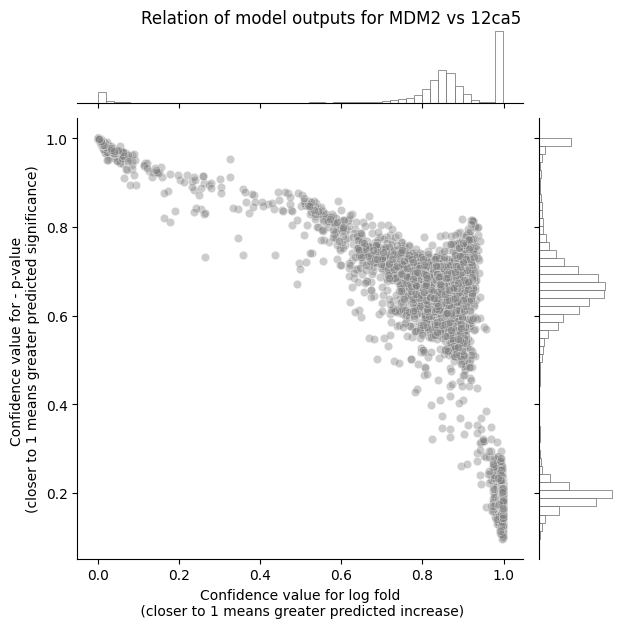

In [6]:
import matplotlib.pyplot as plt
import matplotlib


def show_volcano(
    y,
    title,
    x_label,
    y_label,
    mdm2_ordering=None,
    ca5_ordering=None,
    line_slope=None,
):
    sns.set_palette(sns.color_palette("plasma"))
    p = sns.jointplot(
        x=y[:, 1],
        y=y[:, 0],
        color="grey",
        alpha=0.4,
        marginal_kws=dict(bins=50, fill=False),
    )
    if mdm2_ordering is not None:
        top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-500)[-500]
        plt.scatter(
            x=y[top_mdm2_mask][:, 1],
            y=y[top_mdm2_mask][:, 0],
            color="red",
            alpha=0.8,
        )
    if ca5_ordering is not None:
        top_ca5_mask = ca5_ordering >= np.partition(ca5_ordering, kth=-500)[-500]
        plt.scatter(
            x=y[top_ca5_mask][:, 1],
            y=y[top_ca5_mask][:, 0],
            color="blue",
            alpha=0.8,
        )

    p.fig.suptitle(title)
    p.set_axis_labels(x_label, y_label)
    p.fig.subplots_adjust(top=0.95)  # Reduce plot to make room


show_volcano(
    mdm2_model(X_test),
    title=f"Relation of model outputs for {protein_of_interest} vs {other_protein}",
    x_label="Confidence value for log fold\n (closer to 1 means greater predicted increase)",
    y_label="Confidence value for - p-value \n(closer to 1 means greater predicted significance)",
)


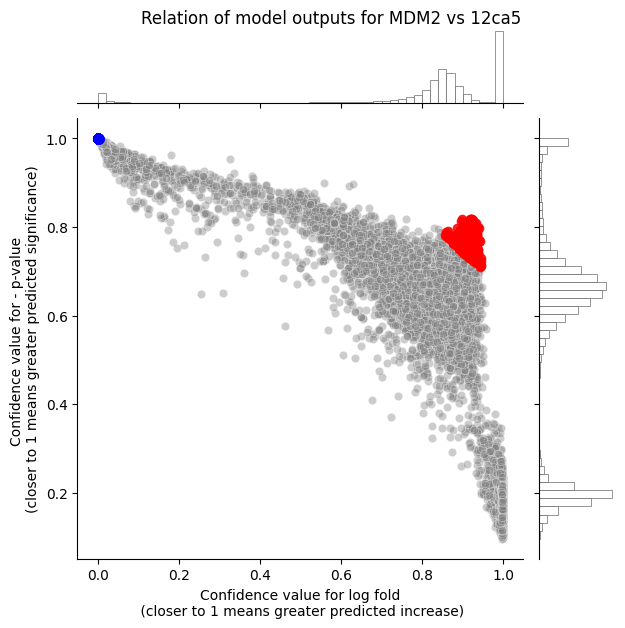

In [10]:
y = mdm2_model(X)
model_mdm2_ordering = np.array(y[:, 0] * (y[:, 1]))
model_ca5_ordering = np.array(y[:, 0] * (1-y[:, 1]))
show_volcano(
    y,
    title=f"Relation of model outputs for {protein_of_interest} vs {other_protein}",
    x_label="Confidence value for log fold\n (closer to 1 means greater predicted increase)",
    y_label="Confidence value for - p-value \n(closer to 1 means greater predicted significance)",
    mdm2_ordering=model_mdm2_ordering,
    ca5_ordering=model_ca5_ordering,
)

In [8]:
print(len(peptides), len(model_mdm2_ordering), len(model_ca5_ordering))

32911 32911 32911


MDM2 area under curve:  290.7616114068448
normalized MDM2 area under curve:  0.5815232228136896
12ca5 area under curve:  351.9251268737159
normalized 12ca5 area under curve:  0.7038502537474318


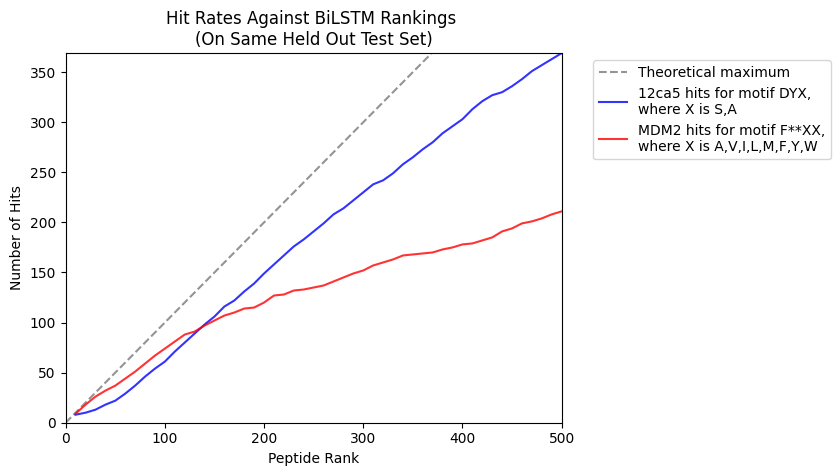

drop C
max is  199.0
drop C
max is  288.0


<AxesSubplot: >

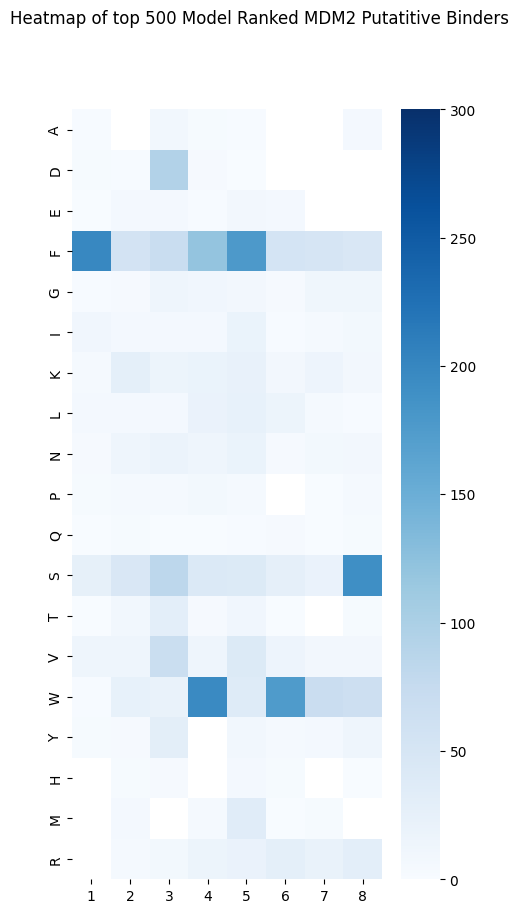

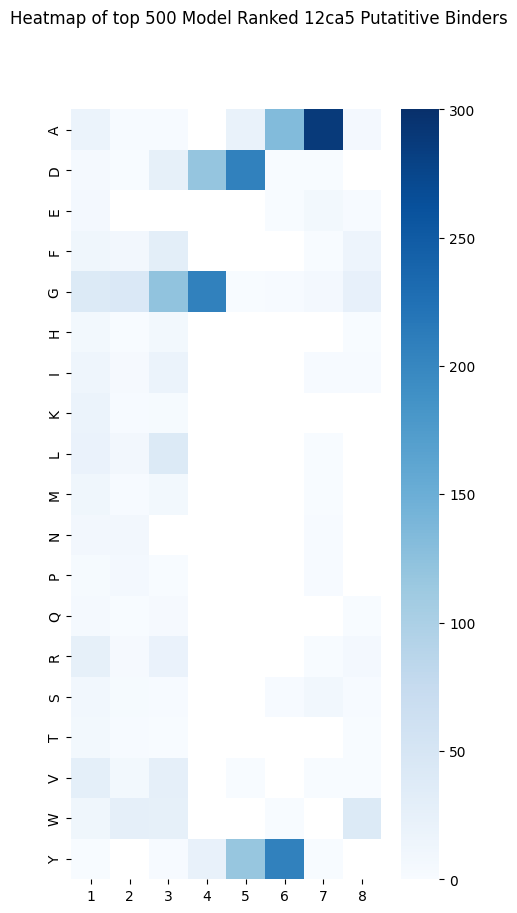

In [26]:
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)

plot_ratio_by_ranking(
    peptides,
    model_mdm2_ordering,
    model_ca5_ordering,
    title="Hit Rates Against BiLSTM Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True,
)
generate_heatmap(
    sort_peptides_by_model_ranking(peptides, model_mdm2_ordering)[:500],
    title="Heatmap of top 500 Model Ranked MDM2 Putatitive Binders",
)
generate_heatmap(
    sort_peptides_by_model_ranking(peptides, model_ca5_ordering)[:500],
    title="Heatmap of top 500 Model Ranked 12ca5 Putatitive Binders",
)


## Hit Rate by Volcano Plot Ground Truth

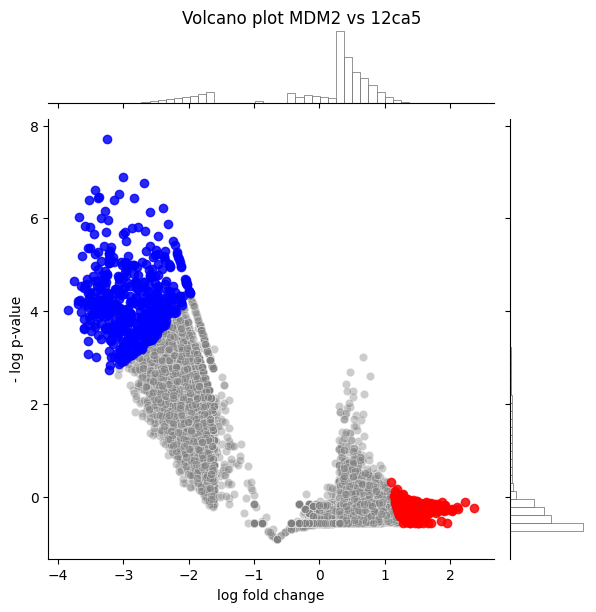

In [8]:
y = mdm2_y_raw #_test
# Slight bump to pvalue for MDM2 since pvalue is so low...
volcano_mdm2_ordering = np.array([(val[0]+6) * val[1] if val[1] > 0 else 0 for val in y])
volcano_ca5_ordering = np.array([-val[0] * val[1] if val[1] < 0 else 0 for val in y])
show_volcano(
    y,
    title=f"Volcano plot {protein_of_interest} vs {other_protein}",
    x_label="log fold change",
    y_label="- log p-value",
    mdm2_ordering=volcano_mdm2_ordering,
    ca5_ordering=volcano_ca5_ordering,
)


In [9]:
print(len(peptides), len(volcano_mdm2_ordering), len(volcano_ca5_ordering))

32911 32911 32911


MDM2 area under curve:  72.1194632801723
normalized MDM2 area under curve:  0.1442389265603446
12ca5 area under curve:  258.2858230244844
normalized 12ca5 area under curve:  0.5165716460489688


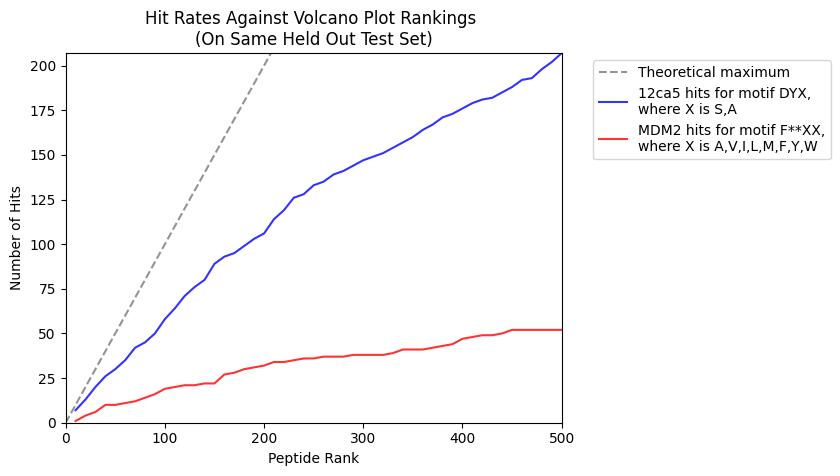

In [10]:
from analysis.hit_rate_analysis import plot_ratio_by_ranking

plot_ratio_by_ranking(
    peptides,
    volcano_mdm2_ordering,
    volcano_ca5_ordering,
    title="Hit Rates Against Volcano Plot Rankings \n(On Same Held Out Test Set)",
    plot_theoretical_maximums=True
)


Fontconfig warning: ignoring UTF-8: not a valid region tag

MUSCLE v3.8.31 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

_example 500 seqs, max length 12, avg  length 8
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      3 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      9 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      9 MB(0%)  Iter   1  100.00%  Root alignment
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


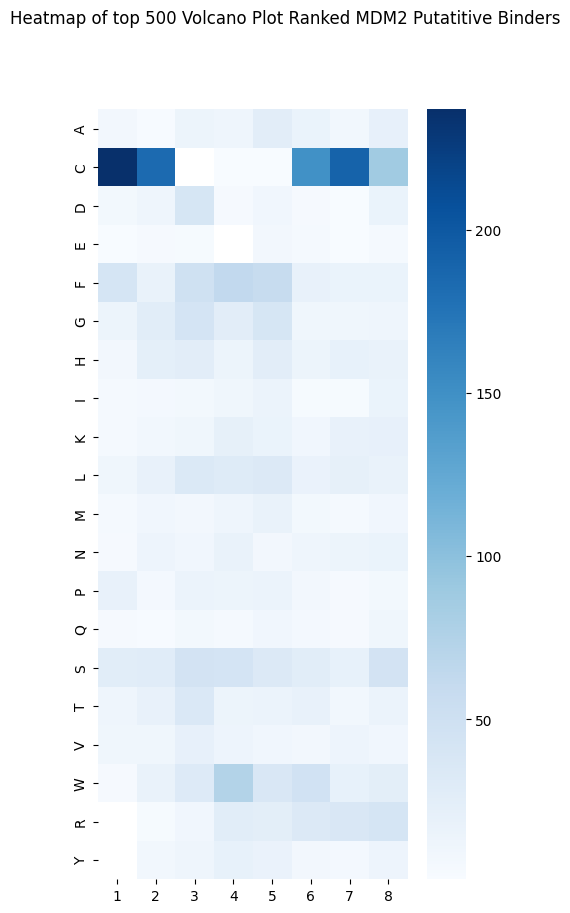

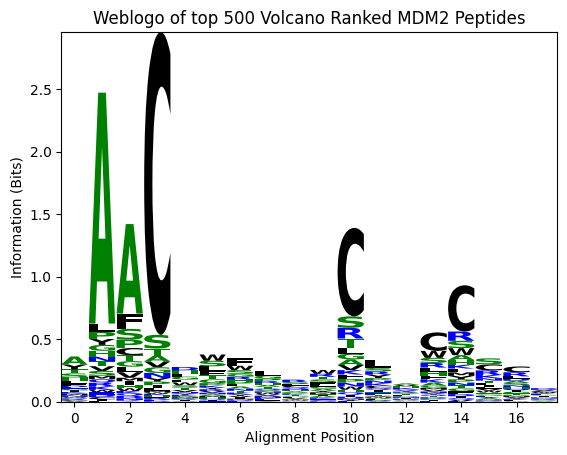

In [11]:
from analysis.create_weblogos import save_web_logo_alignment

sorted_mdm2_peptides = sort_peptides_by_model_ranking(
    peptides, volcano_mdm2_ordering
)
generate_heatmap(
    sorted_mdm2_peptides[:500], title="Heatmap of top 500 Volcano Plot Ranked MDM2 Putatitive Binders"
)
save_web_logo_alignment(
    web_logo_name=None,
    seqs=sorted_mdm2_peptides[:500],
    align=True,
    axis=None,
    to_type="information",
    title='Weblogo of top 500 Volcano Ranked MDM2 Peptides'
)
